In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tabulate import tabulate
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt

import copy
import csv

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [55]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'cat', 'deer', 'dog'}
fg_used = '345'
fg1, fg2, fg3 = 3,4,5

background_classes = {'plane', 'car', 'bird', 'frog', 'horse', 'ship', 'truck'}

# print(type(foreground_classes))

In [0]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)
    

In [0]:
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

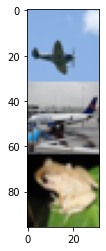

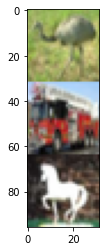

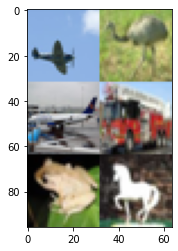

torch.Size([3, 96, 32])


In [59]:
img1 = torch.cat((background_data[0],background_data[1],background_data[2]),1)
imshow(img1)
img2 = torch.cat((background_data[27],background_data[3],background_data[43]),1)
imshow(img2)
img3 = torch.cat((img1,img2),2)
imshow(img3)
print(img2.size())


In [0]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
      label = foreground_label[fg_idx] - fg1  # minus fg1 because our fore ground classes are fg1,fg2,fg3 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [0]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
list_set_labels = [] 
for i in range(desired_num):
  set_idx = set()
  bg_idx = np.random.randint(0,35000,8)
  set_idx = set(background_label[bg_idx].tolist())
  fg_idx = np.random.randint(0,15000)
  set_idx.add(foreground_label[fg_idx].item())
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)
  list_set_labels.append(set_idx)


7


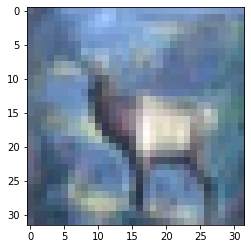

car


In [62]:
qw=45

print(fore_idx[qw])
imshow(mosaic_list_of_images[qw][fore_idx[qw]])
# print(mosaic_list_of_images[0])
print(classes[mosaic_label[qw]]) 

# imshow(mosaic_list_of_images[13][2])
# print(type(mosaic_list_of_images[1][0]))
# print(mosaic_label)

In [0]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [0]:
# class Module1(nn.Module):
#   def __init__(self):
#     super(Module1, self).__init__()
#     self.conv1 = nn.Conv2d(3, 6, 5)
#     self.pool = nn.MaxPool2d(2, 2)
#     self.conv2 = nn.Conv2d(6, 16, 5)
#     self.fc1 = nn.Linear(16 * 5 * 5, 120)
#     self.fc2 = nn.Linear(120, 84)
#     self.fc3 = nn.Linear(84, 10)
#     self.fc4 = nn.Linear(10,1)

#   def forward(self, z):
#     x = torch.zeros([batch,9],dtype=torch.float64)
#     y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
#     x,y = x.to("cuda"),y.to("cuda")
#     for i in range(9):
#       x[:,i] = self.helper(z[:,i])[:,0]
#     x = F.softmax(x,dim=1)   # alphas
    
#     x1 = x[:,0]
#     torch.mul(x1[:,None,None,None],z[:,0])

#     for i in range(9):            
#       x1 = x[:,i]          
#       y = y + torch.mul(x1[:,None,None,None],z[:,i])
#     return y , x 
  
#   def helper(self,x):
#     x = self.pool(F.relu(self.conv1(x)))
#     x = self.pool(F.relu(self.conv2(x)))
#     # x = x.contiguous()
#     # print("x before", x.shape)
#     x = x.view(-1, 16 * 5 * 5)
#     # print("x after", x.shape)
#     x = F.relu(self.fc1(x))
#     x = F.relu(self.fc2(x))
#     x = F.relu(self.fc3(x))
#     x = self.fc4(x)
#     return x

class Module1(nn.Module):
  def __init__(self):
    super(Module1, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,1)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [0]:
# class Module2(nn.Module):
#   def __init__(self):
#     super(Module2, self).__init__()
    
#     self.conv1 = nn.Conv2d(3, 6, 5)
#     self.pool = nn.MaxPool2d(2, 2)
#     self.conv2 = nn.Conv2d(6, 16, 5)
#     self.fc1 = nn.Linear(16 * 5 * 5, 120)
#     self.fc2 = nn.Linear(120, 84)
#     self.fc3 = nn.Linear(84, 10)
#     self.fc4 = nn.Linear(10,3)

#   def forward(self,y):  #z batch of list of 9 images
#     y1 = self.pool(F.relu(self.conv1(y)))
#     y1 = self.pool(F.relu(self.conv2(y1)))
#     # print(y1.shape)
#     y1 = y1.reshape(-1, 16 * 5 * 5)

#     y1 = F.relu(self.fc1(y1))
#     y1 = F.relu(self.fc2(y1))
#     y1 = F.relu(self.fc3(y1))
#     y1 = self.fc4(y1)
#     return y1

class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    self.module1 = Module1().double()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,3)

  def forward(self,z):  #z batch of list of 9 images
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x = torch.zeros([batch,9],dtype=torch.float64)
    x = x.to("cuda")
    y = y.to("cuda")
    for i in range(9):
        x[:,i] = self.module1.forward(z[:,i])[:,0]

    x = F.softmax(x,dim=1)

    x1 = x[:,0]
    torch.mul(x1[:,None,None,None],z[:,0])

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])
      y = y.contiguous()


    y1 = self.pool(F.relu(self.conv1(y)))
    y1 = self.pool(F.relu(self.conv2(y1)))
    y1 = y1.contiguous()
    y1 = y1.reshape(-1, 16 * 5 * 5)

    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)
    return y1 , x, y

In [0]:
# where_net = Module1().double()
# where_net = where_net.to("cuda")

In [0]:
# what_net = Module2().double()
# what_net = what_net.to("cuda")

In [0]:
fore_net = Module2().double()
fore_net = fore_net.to("cuda")

In [69]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# optimizer_where = optim.SGD(where_net.parameters(), lr=0.01, momentum=0.9)
# optimizer_what = optim.SGD(what_net.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.SGD(fore_net.parameters(), lr=0.01, momentum=0.9)
nos_epochs = 600

for epoch in range(nos_epochs):  # loop over the dataset multiple times

  running_loss = 0.0
  cnt=0
  mini_loss = []

  iteration = desired_num // batch
  
  #training data set
  
  for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
    inputs, labels, fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    # zero the parameter gradients
    
    # optimizer_what.zero_grad()
    # optimizer_where.zero_grad()
    optimizer.zero_grad()
    
    # avg_images , alphas = where_net(inputs)
    # avg_images = avg_images.contiguous()
    # outputs = what_net(avg_images)

    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)
#     print(outputs)
#     print(outputs.shape,labels.shape , torch.argmax(outputs, dim=1))

    loss = criterion(outputs, labels) 
    loss.backward()
    # optimizer_what.step()
    # optimizer_where.step()
    optimizer.step()
    running_loss += loss.item()
    mini = 40
  
    if cnt % mini == mini - 1:    # print every 40 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
      mini_loss.append(running_loss / mini)
      running_loss = 0.0
      
    cnt=cnt+1
  if(np.average(mini_loss) <= 0.05):
    break
print('Finished Training')
# torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/drill_deep_cifar/weights/model_epoch"+str(nos_epochs)+".pt")
# torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/drill_deep_cifar/weights/model_epoch"+str(nos_epochs)+".pt")

[1,    40] loss: 1.100
[1,    80] loss: 1.099
[1,   120] loss: 1.099
[2,    40] loss: 1.098
[2,    80] loss: 1.099
[2,   120] loss: 1.099
[3,    40] loss: 1.099
[3,    80] loss: 1.099
[3,   120] loss: 1.098
[4,    40] loss: 1.098
[4,    80] loss: 1.098
[4,   120] loss: 1.098
[5,    40] loss: 1.098
[5,    80] loss: 1.098
[5,   120] loss: 1.098
[6,    40] loss: 1.098
[6,    80] loss: 1.098
[6,   120] loss: 1.098
[7,    40] loss: 1.098
[7,    80] loss: 1.098
[7,   120] loss: 1.098
[8,    40] loss: 1.098
[8,    80] loss: 1.098
[8,   120] loss: 1.097
[9,    40] loss: 1.097
[9,    80] loss: 1.097
[9,   120] loss: 1.097
[10,    40] loss: 1.097
[10,    80] loss: 1.097
[10,   120] loss: 1.096
[11,    40] loss: 1.097
[11,    80] loss: 1.095
[11,   120] loss: 1.095
[12,    40] loss: 1.096
[12,    80] loss: 1.094
[12,   120] loss: 1.094
[13,    40] loss: 1.092
[13,    80] loss: 1.093
[13,   120] loss: 1.094
[14,    40] loss: 1.091
[14,    80] loss: 1.090
[14,   120] loss: 1.091
[15,    40] loss: 1

In [0]:
torch.save(fore_net.state_dict(),"/content/drive/My Drive/Research/drill_deep_cifar/weights/fore_net_epoch"+str(epoch)+"_fg_used"+str(fg_used)+".pt")
# torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/drill_deep_cifar/weights/model_epoch"+str(nos_epochs)+".pt")

In [0]:
# fore_net.load_state_dict(torch.load("/content/drive/My Drive/Research/drill_deep_cifar/weights/fore_net_epoch150_fg_used012.pt"))

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
test_set_labels = []
for i in range(10000):
  set_idx = set()
  bg_idx = np.random.randint(0,35000,8)
  set_idx = set(background_label[bg_idx].tolist())
  fg_idx = np.random.randint(0,15000)
  set_idx.add(foreground_label[fg_idx].item())
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)
  test_set_labels.append(set_idx)


In [0]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [74]:
torch.argmax(alphas[5]), alphas[5]

(tensor(3, device='cuda:0'),
 tensor([0.0125, 0.0348, 0.0074, 0.4648, 0.2884, 0.0043, 0.0578, 0.1015, 0.0286],
        device='cuda:0', dtype=torch.float64, grad_fn=<SelectBackward>))

In [0]:
test_set = DataLoader( test_data,batch_size= batch ,shuffle=False)
train_set = DataLoader( msd,batch_size= batch ,shuffle=False)


###Lets see the % of FTPT, FFPT, FTPF, FFPF for FG classes separetly

In [0]:
fg = [3,4,5]
bg = [0,1,2,6,7,8,9]

In [77]:
from tabulate import tabulate
table = []
entry_no = 1


# cnt=0
for a in fg :
  count = 0
  correct = 0
  total = 0
  focus_true_pred_true = 0
  focus_false_pred_true = 0
  focus_true_pred_false = 0
  focus_false_pred_false = 0
  argmax_more_than_half = 0
  argmax_less_than_half = 0
  with torch.no_grad():
    for data in train_set:
      inputs, labels , fore_idx = data
      inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
      outputs, alphas, avg_images = fore_net(inputs)

      _, predicted = torch.max(outputs.data, 1)

      for m in range(labels.size(0)):
        # count
        if(count == 30000):
          break
        s = list_set_labels[count]
        # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
        if (a in s ):
          # print(str(a)+str(b1)+str(b2)+str(b3))
          total += 1
          focus = torch.argmax(alphas[m])
          if alphas[m][focus] >= 0.5 :
            argmax_more_than_half += 1
          else:
            argmax_less_than_half += 1

          if(focus == fore_idx[m] and predicted[m] == labels[m]):
              focus_true_pred_true += 1
          elif(focus != fore_idx[m] and predicted[m] == labels[m]):
            focus_false_pred_true += 1
          elif(focus == fore_idx[m] and predicted[m] != labels[m]):
            focus_true_pred_false += 1
          elif(focus != fore_idx[m] and predicted[m] != labels[m]):
            focus_false_pred_false += 1
        
        count += 1
      
    correct += (predicted == labels).sum().item()  
    entry = [entry_no,'fg = '+str(a) , 'bg = all_except_fg', total]
    if total == 0:
      entry.append(0)
      entry.append(0)
      entry.append(0)
      entry.append(0)
    else:
      entry.append((100 * focus_true_pred_true / total))
      entry.append( (100 * focus_false_pred_true / total))
      entry.append( ( 100 * focus_true_pred_false / total))
      entry.append( ( 100 * focus_false_pred_false / total))
    entry.append( argmax_more_than_half)
    table.append(entry)
    entry_no += 1

print(tabulate(table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


  S.No.  fg_class    bg_class              data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  ----------  ------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = 3      bg = all_except_fg          10065    60.9836    38.3905   0.248385   0.377546             5772
      2  fg = 4      bg = all_except_fg          10052    48.9156    46.6872   1.59172    2.80541              4230
      3  fg = 5      bg = all_except_fg           9883    75.6855    21.6129   1.20409    1.49752              7148


In [78]:
# for testing_set
table = []
entry_no = 1

# cnt=0
for a in fg :
  count = 0
  correct = 0
  total = 0
  focus_true_pred_true = 0
  focus_false_pred_true = 0
  focus_true_pred_false = 0
  focus_false_pred_false = 0
  argmax_more_than_half = 0
  argmax_less_than_half = 0
  with torch.no_grad():
    for data in test_set:
      inputs, labels , fore_idx = data
      inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
      outputs, alphas, avg_images = fore_net(inputs)

      _, predicted = torch.max(outputs.data, 1)

      for m in range(labels.size(0)):
        # count
        if(count == 10000):
          break
        s = list_set_labels[count]
        # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
        if (a in s ):
          # print(str(a)+str(b1)+str(b2)+str(b3))
          total += 1
          focus = torch.argmax(alphas[m])
          if alphas[m][focus] >= 0.5 :
            argmax_more_than_half += 1
          else:
            argmax_less_than_half += 1

          if(focus == fore_idx[m] and predicted[m] == labels[m]):
              focus_true_pred_true += 1
          elif(focus != fore_idx[m] and predicted[m] == labels[m]):
            focus_false_pred_true += 1
          elif(focus == fore_idx[m] and predicted[m] != labels[m]):
            focus_true_pred_false += 1
          elif(focus != fore_idx[m] and predicted[m] != labels[m]):
            focus_false_pred_false += 1
        
        count += 1
      
    correct += (predicted == labels).sum().item()  
    entry = [entry_no,'fg = '+str(a) , 'bg = all_except_fg', total]
    if total == 0:
      entry.append(0)
      entry.append(0)
      entry.append(0)
      entry.append(0)
    else:
      entry.append((100 * focus_true_pred_true / total))
      entry.append( (100 * focus_false_pred_true / total))
      entry.append( ( 100 * focus_true_pred_false / total))
      entry.append( ( 100 * focus_false_pred_false / total))
    entry.append( argmax_more_than_half)
    table.append(entry)
    entry_no += 1

print(tabulate(table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


  S.No.  fg_class    bg_class              data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  ----------  ------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = 3      bg = all_except_fg           3339    46.1216    16.0228    13.1476    24.708              1810
      2  fg = 4      bg = all_except_fg           3416    46.0773    16.8033    13.0269    24.0925             1851
      3  fg = 5      bg = all_except_fg           3245    44.6225    15.963     13.6518    25.7627             1771


###Lets see the % of FTPT, FFPT, FTPF, FFPF for FG classes with 3 bg classes separetly


In [79]:
fg, str(fg)

([3, 4, 5], '[3, 4, 5]')

In [80]:
from tabulate import tabulate
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_set:
    inputs, labels , fore_idx = data
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      count += 1
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)
print(count)

print("="*100)
table = []
entry = [1,'fg = '+ str(fg),'bg = '+str(bg),30000]
entry.append((100 * focus_true_pred_true / total))
entry.append( (100 * focus_false_pred_true / total))
entry.append( ( 100 * focus_true_pred_false / total))
entry.append( ( 100 * focus_false_pred_false / total))
entry.append( argmax_more_than_half)
table.append(entry)

print(tabulate(table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT', 'FFPT', 'FTPF', 'FFPF', 'avg_img > 0.5'] ) )


Accuracy of the network on the 30000 train images: 97 %
total correct 29228
total train set images 30000
focus_true_pred_true 18535 =============> FTPT : 61 %
focus_false_pred_true 10693 =============> FFPT : 35 %
focus_true_pred_false 304 =============> FTPF : 1 %
focus_false_pred_false 468 =============> FFPF : 1 %
argmax_more_than_half 17150
argmax_less_than_half 12850
30000
  S.No.  fg_class        bg_class                      data_points     FTPT     FFPT     FTPF    FFPF    avg_img > 0.5
-------  --------------  --------------------------  -------------  -------  -------  -------  ------  ---------------
      1  fg = [3, 4, 5]  bg = [0, 1, 2, 6, 7, 8, 9]          30000  61.7833  35.6433  1.01333    1.56            17150


In [81]:
entry_no = 2

# cnt=0
for a in fg :
  for i in range(5):
    b1 = bg[i]
    for j in range(i+1 , 6): 
      b2 = bg[j]
      for k in range(j+1 , 7):
        b3 = bg[k]
        # cnt+=1
        # print( cnt , a,b1,b2,b3)
        count = 0
        correct = 0
        total = 0
        focus_true_pred_true = 0
        focus_false_pred_true = 0
        focus_true_pred_false = 0
        focus_false_pred_false = 0
        argmax_more_than_half = 0
        argmax_less_than_half = 0
        with torch.no_grad():
          for data in train_set:
            inputs, labels , fore_idx = data
            inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
            outputs, alphas, avg_images = fore_net(inputs)

            _, predicted = torch.max(outputs.data, 1)

            for m in range(labels.size(0)):
              # count
              if(count == 30000):
                break
              s = list_set_labels[count]
              # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
              if (a in s and b1 in s and b2 in s and b3 in s):
                # print(str(a)+str(b1)+str(b2)+str(b3))
                total += 1
                focus = torch.argmax(alphas[m])
                if alphas[m][focus] >= 0.5 :
                  argmax_more_than_half += 1
                else:
                  argmax_less_than_half += 1

                if(focus == fore_idx[m] and predicted[m] == labels[m]):
                    focus_true_pred_true += 1
                elif(focus != fore_idx[m] and predicted[m] == labels[m]):
                  focus_false_pred_true += 1
                elif(focus == fore_idx[m] and predicted[m] != labels[m]):
                  focus_true_pred_false += 1
                elif(focus != fore_idx[m] and predicted[m] != labels[m]):
                  focus_false_pred_false += 1
              
              count += 1
            
          correct += (predicted == labels).sum().item()  
          entry = [entry_no,'fg = '+str(a) , 'bg = '+ str(b1)+',' + str(b2)+',' + str(b3), total]
          if total == 0:
            entry.append(0)
            entry.append(0)
            entry.append(0)
            entry.append(0)
          else:
            entry.append((100 * focus_true_pred_true / total))
            entry.append( (100 * focus_false_pred_true / total))
            entry.append( ( 100 * focus_true_pred_false / total))
            entry.append( ( 100 * focus_false_pred_false / total))
          entry.append( argmax_more_than_half)
          table.append(entry)
          entry_no += 1

print(tabulate(table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [3, 4, 5]  bg = [0, 1, 2, 6, 7, 8, 9]          30000    61.7833    35.6433  1.01333     1.56                17150
      2  fg = 3          bg = 0,1,2                           3174    61.0271    38.2483  0.346566    0.378072             1855
      3  fg = 3          bg = 0,1,6                           3245    61.7874    37.7196  0.123267    0.3698               1912
      4  fg = 3          bg = 0,1,7                           3241    62.419     36.9948  0.185128    0.401111             1925
      5  fg = 3          bg = 0,1,8                           3302    62.659     36.705   0.272562    0.363416             1983
      6  fg = 3          bg = 0,1,9                           3254    64.4438    35.0338  0.245851    0.

In [0]:
col = ['configuration','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5']
# df_train = pd.DataFrame()
import csv
with open("/content/drive/My Drive/Research/drill_deep_cifar/train"+str(fg_used)+".csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(table)
  thewriter.writerow(['S.No.','configuration','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(table[i])

In [83]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_set:
    inputs, labels , fore_idx = data
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

print("="*100)
table = []
entry = [1,'fg = '+ str(fg),'bg = '+str(bg),10000]
entry.append((100 * focus_true_pred_true / total))
entry.append( (100 * focus_false_pred_true / total))
entry.append( ( 100 * focus_true_pred_false / total))
entry.append( ( 100 * focus_false_pred_false / total))
entry.append( argmax_more_than_half)
table.append(entry)

print(tabulate(table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT', 'FFPT', 'FTPF', 'FFPF', 'avg_img > 0.5'] ) )


Accuracy of the network on the 10000 train images: 61 %
total correct 6189
total train set images 10000
focus_true_pred_true 4562 =============> FTPT : 45 %
focus_false_pred_true 1627 =============> FFPT : 16 %
focus_true_pred_false 1327 =============> FTPF : 13 %
focus_false_pred_false 2484 =============> FFPF : 24 %
argmax_more_than_half 5432
argmax_less_than_half 4568
  S.No.  fg_class        bg_class                      data_points    FTPT    FFPT    FTPF    FFPF    avg_img > 0.5
-------  --------------  --------------------------  -------------  ------  ------  ------  ------  ---------------
      1  fg = [3, 4, 5]  bg = [0, 1, 2, 6, 7, 8, 9]          10000   45.62   16.27   13.27   24.84             5432


In [84]:
entry_no = 2
#usinfg test_loader
# fg = [0,1,2]
# bg = [3,4,5,6,7,8,9]

# cnt=0
for a in fg :
  for i in range(5):
    b1 = bg[i]
    for j in range(i+1 , 6): 
      b2 = bg[j]
      for k in range(j+1 , 7):
        b3 = bg[k]
        # cnt+=1
        # print( cnt , a,b1,b2,b3)
        count = 0
        correct = 0
        total = 0
        focus_true_pred_true = 0
        focus_false_pred_true = 0
        focus_true_pred_false = 0
        focus_false_pred_false = 0
        argmax_more_than_half = 0
        argmax_less_than_half = 0
        with torch.no_grad():
          for data in test_set:
            inputs, labels , fore_idx = data
            inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
            outputs, alphas, avg_images = fore_net(inputs)

            _, predicted = torch.max(outputs.data, 1)

            for m in range(labels.size(0)):
              # count
              if(count == 10000):
                break
              s = test_set_labels[count]
              # print(count, s, str(a)+str(b1)+str(b2)+str(b3))
              if (a in s and b1 in s and b2 in s and b3 in s):
                # print(str(a)+str(b1)+str(b2)+str(b3))
                total += 1
                focus = torch.argmax(alphas[m])
                if alphas[m][focus] >= 0.5 :
                  argmax_more_than_half += 1
                else:
                  argmax_less_than_half += 1

                if(focus == fore_idx[m] and predicted[m] == labels[m]):
                    focus_true_pred_true += 1
                elif(focus != fore_idx[m] and predicted[m] == labels[m]):
                  focus_false_pred_true += 1
                elif(focus == fore_idx[m] and predicted[m] != labels[m]):
                  focus_true_pred_false += 1
                elif(focus != fore_idx[m] and predicted[m] != labels[m]):
                  focus_false_pred_false += 1
              
              count += 1
            
          correct += (predicted == labels).sum().item()  
          entry = [entry_no,'fg = '+str(a) , 'bg = '+ str(b1)+',' + str(b2)+',' + str(b3), total]
          if total == 0:
            entry.append(0)
            entry.append(0)
            entry.append(0)
            entry.append(0)
          else:
            entry.append((100 * focus_true_pred_true / total))
            entry.append( (100 * focus_false_pred_true / total))
            entry.append( ( 100 * focus_true_pred_false / total))
            entry.append( ( 100 * focus_false_pred_false / total))
          entry.append( argmax_more_than_half)
          table.append(entry)
          entry_no += 1

print(tabulate(table, headers=['S.No.', 'fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'] ) )


  S.No.  fg_class        bg_class                      data_points    FTPT %     FFPT %     FTPF %     FFPF %     avg_img > 0.5
-------  --------------  --------------------------  -------------  ---------  ---------  ---------  ---------  ---------------
      1  fg = [3, 4, 5]  bg = [0, 1, 2, 6, 7, 8, 9]          10000    45.62     16.27      13.27       24.84               5432
      2  fg = 3          bg = 0,1,2                           1056    48.7689   18.9394    10.7008     21.5909              584
      3  fg = 3          bg = 0,1,6                           1020    48.6275   20.2941     9.21569    21.8627              556
      4  fg = 3          bg = 0,1,7                           1058    48.0151   19.0926    10.586      22.3062              600
      5  fg = 3          bg = 0,1,8                           1067    49.2034   18.8379    11.3402     20.6186              624
      6  fg = 3          bg = 0,1,9                           1082    50.4621   18.7616    10.9982     1

In [0]:
col = ['fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5']

In [0]:
import csv
with open("/content/drive/My Drive/Research/drill_deep_cifar/test"+str(fg_used)+".csv", "w", newline ='') as f:
  thewriter = csv.writer(f)
  row = len(table)
  thewriter.writerow(['S.No.','fg_class','bg_class','data_points','FTPT % ', 'FFPT % ', 'FTPF % ', 'FFPF % ', 'avg_img > 0.5'])
  for i in range(row):
    thewriter.writerow(table[i])

In [87]:
test = pd.read_csv("/content/drive/My Drive/Research/drill_deep_cifar/test"+str(fg_used)+".csv")
test.head()

,S.No.,fg_class,bg_class,data_points,FTPT %,FFPT %,FTPF %,FFPF %,avg_img > 0.5
0,1,"fg = [3, 4, 5]","bg = [0, 1, 2, 6, 7, 8, 9]",10000,45.620000,16.270000,13.270000,24.840000,5432
1,2,fg = 3,"bg = 0,1,2",1056,48.768939,18.939394,10.700758,21.590909,584
2,3,fg = 3,"bg = 0,1,6",1020,48.627451,20.294118,9.215686,21.862745,556
3,4,fg = 3,"bg = 0,1,7",1058,48.015123,19.092628,10.586011,22.306238,600
4,5,fg = 3,"bg = 0,1,8",1067,49.203374,18.837863,11.340206,20.618557,624


In [0]:
test = np.array(test)

In [89]:
len(test)

106

In [90]:
ftpt_full = test[0][4]
ffpt_full = test[0, 5]
ftpf_full = test[0, 6]
ffpf_full = test[0][7]
ftpt_full, ffpt_full, ftpf_full, ffpf_full

(45.62, 16.27, 13.27, 24.84)

In [91]:
id0 = test[1:35, 2]
ftpt0 = test[1:35, 4]
ffpt0 = test[1:35, 5]
ftpf0 = test[1:35, 6]
ffpf0 = test[1:35, 7]
ftpt0 , id0

(array([48.76893939393939, 48.62745098039216, 48.01512287334594,
        49.20337394564199, 50.46210720887246, 45.60229445506693,
        46.19047619047619, 46.19002822201317, 46.660482374768094,
        47.31610337972167, 46.851145038167935, 48.25688073394495,
        47.368421052631575, 48.282442748091604, 48.27586206896552,
        45.2561669829222, 45.53817847286109, 45.01372369624885,
        46.861184792219284, 45.47206165703275, 45.97918637653737,
        48.68778280542986, 46.14670380687094, 48.41341795104261,
        48.19494584837546, 43.23809523809525, 42.495309568480295,
        45.14388489208634, 43.546889507892296, 45.27272727272727,
        44.09090909090909, 44.54976303317535, 47.075208913649035,
        46.72645739910313], dtype=object),
 array(['bg = 0,1,2', 'bg = 0,1,6', 'bg = 0,1,7', 'bg = 0,1,8',
        'bg = 0,1,9', 'bg = 0,2,6', 'bg = 0,2,7', 'bg = 0,2,8',
        'bg = 0,2,9', 'bg = 0,6,7', 'bg = 0,6,8', 'bg = 0,6,9',
        'bg = 0,7,8', 'bg = 0,7,9', 'bg = 0

In [0]:
id1 = test[36:70, 2]
ftpt1 = test[36:70, 4]
ffpt1 = test[36:70, 5]
ftpf1 = test[36:70, 6]
ffpf1 = test[36:70, 7]

id2 = test[71:105, 2]
ftpt2 = test[71:105, 4]
ffpt2 = test[71:105, 5]
ftpf2 = test[71:105, 6]
ffpf2 = test[71:105, 7]

In [0]:
path = '/content/drive/My Drive/Research/drill_deep_cifar/plots/fg_'+str(fg_used)+'/'

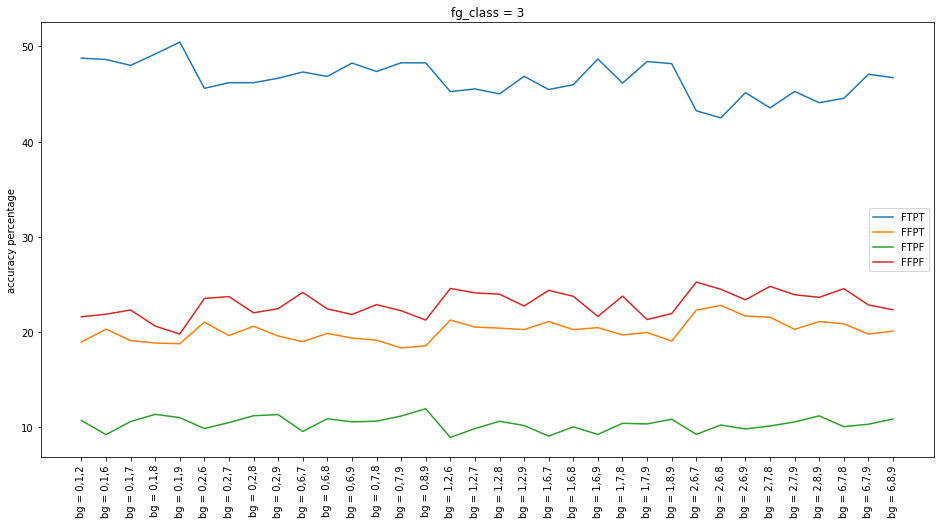

In [94]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt0,label = 'FTPT')
plt.plot(id0, ffpt0 , label = 'FFPT')
plt.plot(id0, ftpf0, label = 'FTPF')
plt.plot(id0, ffpf0, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg1))
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg1)+".pdf", bbox_inches='tight')

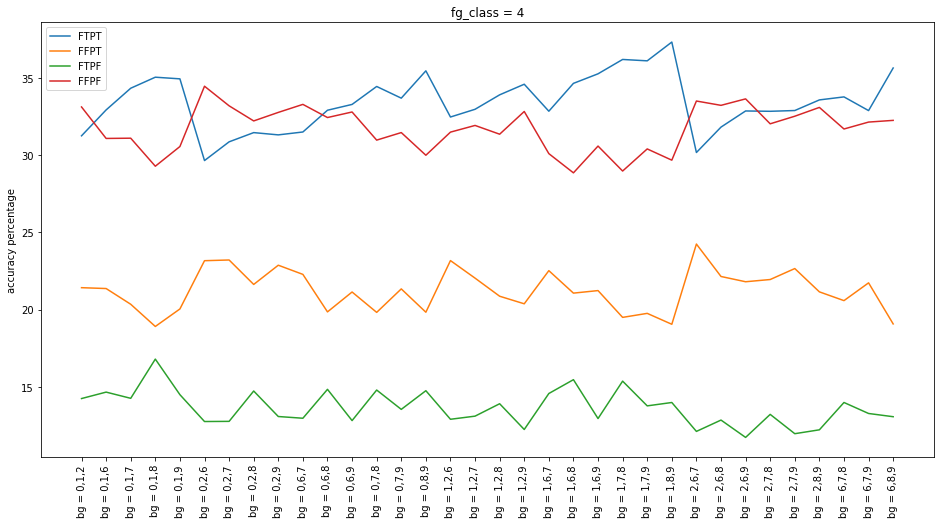

In [95]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt1,label = 'FTPT')
plt.plot(id0, ffpt1 , label = 'FFPT')
plt.plot(id0, ftpf1, label = 'FTPF')
plt.plot(id0, ffpf1, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg2))
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg2)+".pdf", bbox_inches='tight')

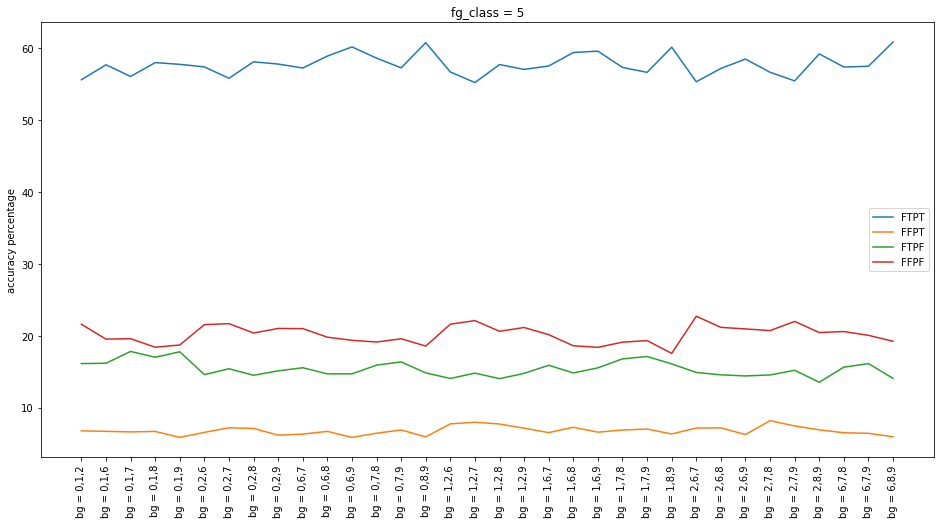

In [96]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0, ftpt2,label = 'FTPT')
plt.plot(id0, ffpt2 , label = 'FFPT')
plt.plot(id0, ftpf2, label = 'FTPF')
plt.plot(id0, ffpf2, label = 'FFPF')
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('fg_class = '+ str(fg3))
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path + "fg_class"+str(fg3)+".pdf", bbox_inches='tight')

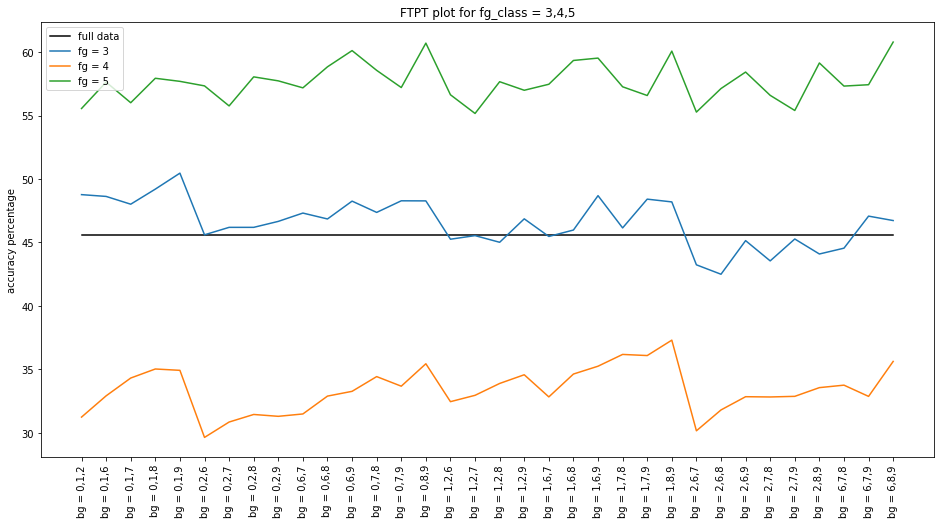

In [97]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpt_full, color='black', label = 'full data')
plt.plot(id0, ftpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3))
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpt_plot.pdf", bbox_inches='tight')

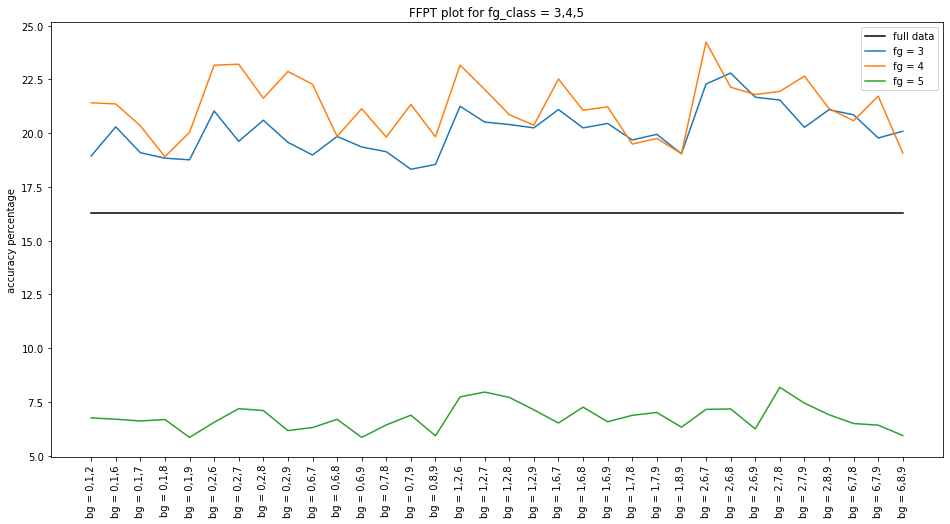

In [98]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpt_full, color='black', label = 'full data')
plt.plot(id0, ffpt0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpt1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpt2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPT plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3))
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpt_plot.pdf", bbox_inches='tight')

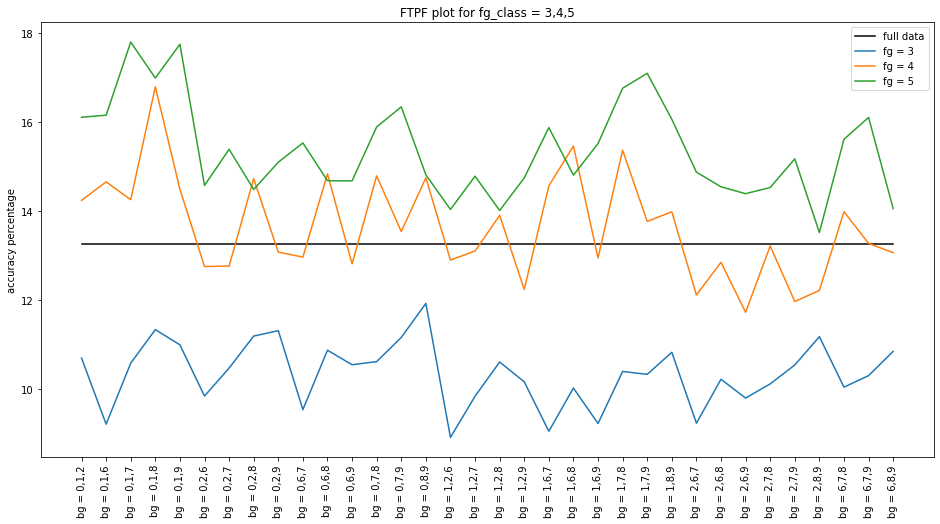

In [99]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ftpf_full, color='black', label = 'full data')
plt.plot(id0, ftpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ftpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ftpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FTPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3))
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ftpf_plot.pdf", bbox_inches='tight')

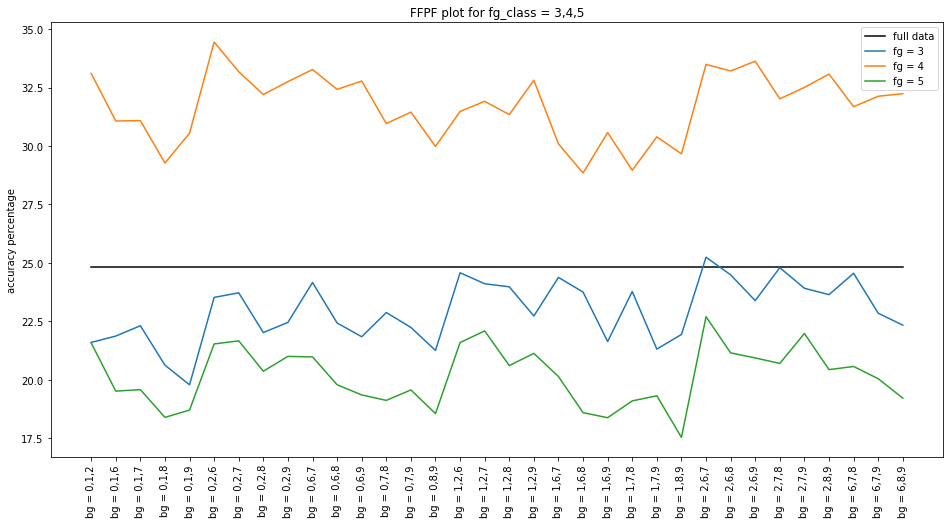

In [100]:
fig = plt.figure( figsize= (16,8))
plt.plot(id0,np.ones(len(id0))*ffpf_full, color='black', label = 'full data')
plt.plot(id0, ffpf0, label = 'fg = '+str(fg1))
plt.plot(id0, ffpf1, label = 'fg = '+str(fg2))
plt.plot(id0, ffpf2, label = 'fg = '+str(fg3))
plt.xticks(id0, rotation=90)
plt.legend()
plt.title('FFPF plot for fg_class = ' + str(fg1) + ',' + str(fg2) + ',' + str(fg3))
plt.ylabel('accuracy percentage')
plt.show()
fig.savefig(path+"ffpf_plot.pdf", bbox_inches='tight')